## Requirements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import math

## Dataset Preparation

In [2]:
df_train = pd.read_csv("data/data_train.csv", encoding='utf-8')
df_test = pd.read_csv("data/data_test.csv", encoding='utf-8')
print("Info data training awal:")
df_train.info()
print("\n")

Info data training awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 24336 non-null  int64  
 1   tanggal_waktu      24336 non-null  object 
 2   suhu               24336 non-null  float64
 3   beban_listrik      24336 non-null  float64
 4   kecepatan_angin    24336 non-null  float64
 5   tekanan_udara      24336 non-null  float64
 6   dampak_lingkungan  24336 non-null  object 
 7   konsumsi_listrik   24283 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.5+ MB




## Preprocessing

In [3]:
df_train["tanggal_waktu"] = pd.to_datetime(df_train["tanggal_waktu"])
df_test["tanggal_waktu"] = pd.to_datetime(df_test["tanggal_waktu"])

In [4]:
# Cek missing values
print(df_train.isnull().sum())

ID                    0
tanggal_waktu         0
suhu                  0
beban_listrik         0
kecepatan_angin       0
tekanan_udara         0
dampak_lingkungan     0
konsumsi_listrik     53
dtype: int64


In [5]:
# Isi missing values jika ada
df_train["tekanan_udara"] = df_train["tekanan_udara"].fillna(df_train["tekanan_udara"].interpolate())
df_train["konsumsi_listrik"] = df_train["konsumsi_listrik"].fillna(method="ffill")

print(df_train.isnull().sum())

ID                   0
tanggal_waktu        0
suhu                 0
beban_listrik        0
kecepatan_angin      0
tekanan_udara        0
dampak_lingkungan    0
konsumsi_listrik     0
dtype: int64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10308\1436221346.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train["konsumsi_listrik"] = df_train["konsumsi_listrik"].fillna(method="ffill")


In [6]:
# Encode dampak_lingkungan
df_train = pd.get_dummies(df_train, columns=["dampak_lingkungan"])
df_test = pd.get_dummies(df_test, columns=["dampak_lingkungan"])

df_train.head()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik,dampak_lingkungan_A,dampak_lingkungan_B,dampak_lingkungan_C
0,0,2021-09-17 00:00:00,15.9,-17.1,571.910,1003.0,216.0,True,False,False
1,1,2021-09-17 01:00:00,15.5,-19.3,575.040,996.0,210.0,True,False,False
2,2,2021-09-17 02:00:00,15.1,-20.0,578.435,1000.0,225.0,True,False,False
3,3,2021-09-17 03:00:00,15.9,-17.1,582.580,995.0,216.0,True,False,False
4,4,2021-09-17 04:00:00,15.9,-19.3,586.600,1005.0,222.0,True,False,False


In [7]:
# Sort sesuai dengan tanggal_waktu
df_cleaned = df_train.sort_values("tanggal_waktu")
df_test = df_test.sort_values("tanggal_waktu")
df_cleaned.head()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik,dampak_lingkungan_A,dampak_lingkungan_B,dampak_lingkungan_C
0,0,2021-09-17 00:00:00,15.9,-17.1,571.910,1003.0,216.0,True,False,False
1,1,2021-09-17 01:00:00,15.5,-19.3,575.040,996.0,210.0,True,False,False
2,2,2021-09-17 02:00:00,15.1,-20.0,578.435,1000.0,225.0,True,False,False
3,3,2021-09-17 03:00:00,15.9,-17.1,582.580,995.0,216.0,True,False,False
4,4,2021-09-17 04:00:00,15.9,-19.3,586.600,1005.0,222.0,True,False,False


In [8]:
# Cek outlier
df_cleaned.describe()

,ID,tanggal_waktu,suhu,beban_listrik,kecepatan_angin,tekanan_udara,konsumsi_listrik
count,24336.000000,24336,24336.000000,24336.000000,24336.000000,24336.000000,24336.000000
mean,16027.381657,2023-07-16 19:22:53.964496896,25.161082,-1.783510,23.631823,986.012964,531.997411
min,0.000000,2021-09-17 00:00:00,12.700000,-32.900000,1.075000,953.000000,174.000000
25%,8051.750000,2022-08-18 11:45:00,21.100000,-10.700000,3.165000,977.000000,219.000000
50%,16079.500000,2023-07-18 23:30:00,25.800000,-1.400000,6.670000,986.000000,270.000000
75%,24155.250000,2024-06-19 11:15:00,29.400000,7.900000,22.700000,995.000000,342.000000
max,32183.000000,2025-05-19 23:00:00,35.300000,18.600000,586.600000,1024.000000,99999.000000
std,9299.957517,NaN,4.888658,10.521302,46.781818,12.130831,4820.776434


In [9]:
df_train_interpolated = df_cleaned.copy()

# 1. Hitung batas atas
Q1 = df_train_interpolated['konsumsi_listrik'].quantile(0.25)
Q3 = df_train_interpolated['konsumsi_listrik'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# 2. Ganti outlier dengan NaN
df_train_interpolated.loc[df_train_interpolated['konsumsi_listrik'] > upper_bound, 'konsumsi_listrik'] = np.nan

# 3. Lakukan interpolasi berbasis waktu
df_train_interpolated.set_index('tanggal_waktu', inplace=True)
df_train_interpolated['konsumsi_listrik'].interpolate(method='time', inplace=True)
df_train_interpolated.reset_index(inplace=True) # Kembalikan index seperti semula

print("Proses Interpolasi selesai. Gunakan 'df_train_interpolated' untuk training.")

df_train_interpolated.info()

Proses Interpolasi selesai. Gunakan 'df_train_interpolated' untuk training.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24336 entries, 0 to 24335
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   tanggal_waktu        24336 non-null  datetime64[ns]
 1   ID                   24336 non-null  int64         
 2   suhu                 24336 non-null  float64       
 3   beban_listrik        24336 non-null  float64       
 4   kecepatan_angin      24336 non-null  float64       
 5   tekanan_udara        24336 non-null  float64       
 6   konsumsi_listrik     24336 non-null  float64       
 7   dampak_lingkungan_A  24336 non-null  bool          
 8   dampak_lingkungan_B  24336 non-null  bool          
 9   dampak_lingkungan_C  24336 non-null  bool          
dtypes: bool(3), datetime64[ns](1), float64(5), int64(1)
memory usage: 1.4 MB


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10308\3510887517.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_interpolated['konsumsi_listrik'].interpolate(method='time', inplace=True)


In [10]:
# Menambahkan fitur-fitur baru dari kolom `tanggal_waktu` untuk memberikan lebih banyak informasi kepada model.
def feature_engineer(df):
    df['hour'] = df['tanggal_waktu'].dt.hour
    df['day_of_week'] = df['tanggal_waktu'].dt.dayofweek
    df['day_of_year'] = df['tanggal_waktu'].dt.dayofyear
    df['month'] = df['tanggal_waktu'].dt.month

    # Fitur Siklikal untuk jam
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    df = df.drop('hour', axis=1)
    # Tidak perlu get_dummies karena sudah ada dampak_lingkungan_A/B/C
    return df

df_train_featured = feature_engineer(df_train_interpolated)
df_test_featured = feature_engineer(df_test)
print("Data setelah feature engineering:")
print(df_train_featured.head())
print("\n")

Data setelah feature engineering:
        tanggal_waktu  ID  suhu  beban_listrik  kecepatan_angin  \
0 2021-09-17 00:00:00   0  15.9          -17.1          571.910   
1 2021-09-17 01:00:00   1  15.5          -19.3          575.040   
2 2021-09-17 02:00:00   2  15.1          -20.0          578.435   
3 2021-09-17 03:00:00   3  15.9          -17.1          582.580   
4 2021-09-17 04:00:00   4  15.9          -19.3          586.600   

   tekanan_udara  konsumsi_listrik  dampak_lingkungan_A  dampak_lingkungan_B  \
0         1003.0             216.0                 True                False   
1          996.0             210.0                 True                False   
2         1000.0             225.0                 True                False   
3          995.0             216.0                 True                False   
4         1005.0             222.0                 True                False   

   dampak_lingkungan_C  day_of_week  day_of_year  month  hour_sin  hour_cos  
0   

In [11]:
# Menyiapkan data final untuk model
test_ids = df_test_featured['ID'].copy()
test_dates = df_test_featured['tanggal_waktu'].copy() # Simpan tanggal untuk visualisasi

df_train_final = df_train_featured.drop(['ID', 'tanggal_waktu'], axis=1)
df_test_final = df_test_featured.drop(['ID', 'tanggal_waktu'], axis=1)

In [12]:
# Pastikan kolom train dan test sama persis
train_cols = df_train_final.drop('konsumsi_listrik', axis=1).columns
for col in train_cols:
    if col not in df_test_final.columns:
        df_test_final[col] = 0
df_test_final = df_test_final[train_cols]
print("Preprocessing selesai.\n")

Preprocessing selesai.



## EDA

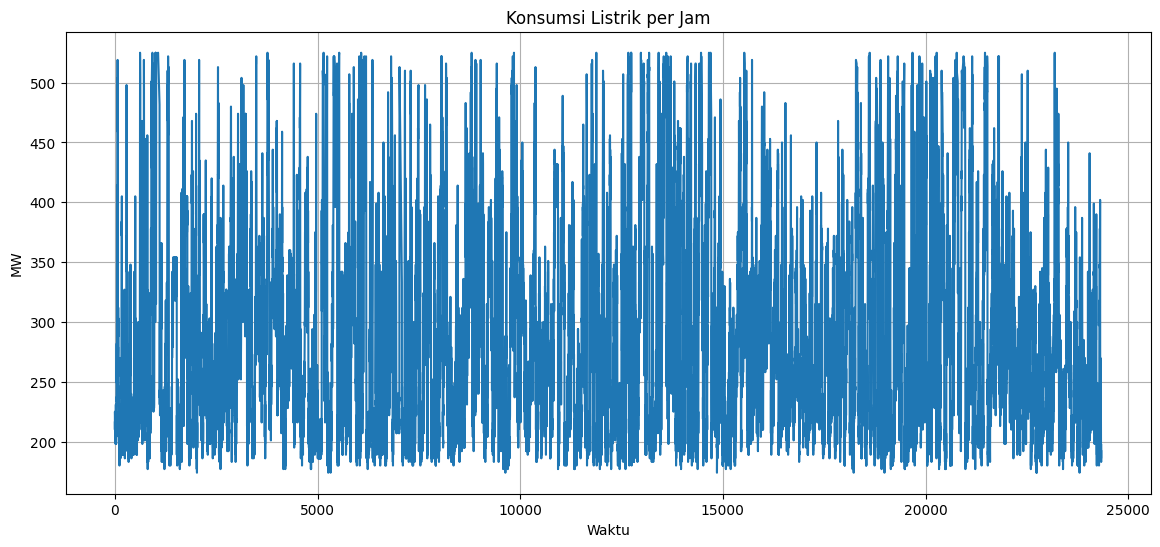

In [13]:
plt.figure(figsize=(14,6))
plt.plot(df_train_final.index, df_train_final['konsumsi_listrik'])
plt.title("Konsumsi Listrik per Jam")
plt.xlabel("Waktu")
plt.ylabel("MW")
plt.grid(True)
plt.show()

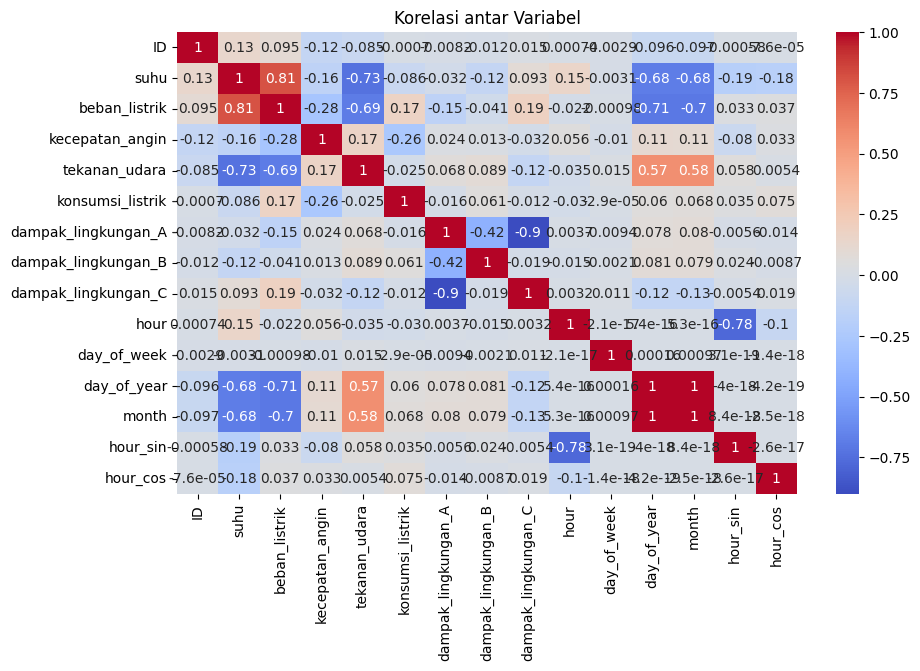

In [14]:
# Korelasi antar fitur
plt.figure(figsize=(10,6))
sns.heatmap(df_train_interpolated.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Korelasi antar Variabel")
plt.show()

## Modelling

### GRU

In [15]:
# Pisahkan fitur (X) dan target (y)
X = df_train_final.drop('konsumsi_listrik', axis=1).values
y = df_train_final['konsumsi_listrik'].values.reshape(-1, 1)

In [16]:
# Scaling fitur dan target secara terpisah
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [17]:
# Fungsi untuk membuat sekuens data untuk model RNN
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        if y is not None:
            ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 48 # Coba window yang lebih besar (2 hari)
X_seq, y_seq = create_dataset(X_scaled, y_scaled, TIME_STEPS)

In [18]:
# Split data menjadi training dan validation set
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)
print(f"Bentuk data training: {X_train.shape}")
print(f"Bentuk data validasi: {X_val.shape}\n")

Bentuk data training: (19430, 48, 12)
Bentuk data validasi: (4858, 48, 12)



In [19]:
print("--- Membangun Model GRU ---")
def build_gru_model(input_shape):
    model = Sequential([
        Bidirectional(GRU(units=100, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(GRU(units=50)),
        Dropout(0.3),
        Dense(units=25, activation='relu'),
        Dense(units=1)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# ### Model 2: Bidirectional LSTM
print("--- Membangun Model LSTM ---")
def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(units=100, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(units=50)),
        Dropout(0.3),
        Dense(units=25, activation='relu'),
        Dense(units=1)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

--- Membangun Model GRU ---
--- Membangun Model LSTM ---


In [20]:
# Training Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [21]:
# Melatih Model GRU
print("\n--- Melatih Model GRU ---")
model_gru = build_gru_model((X_train.shape[1], X_train.shape[2]))
history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=1)


--- Melatih Model GRU ---


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - loss: 0.0586 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 2/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0378 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 3/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0344 - val_loss: 0.0332 - learning_rate: 0.0010
Epoch 4/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0332 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 5/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0318 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 6/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.0313 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 7/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 0.0301 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 8/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.0298 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 9/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.0271 - val_loss: 0.0317 - learn

In [22]:
# Melatih Model LSTM
print("\n--- Melatih Model LSTM ---")
model_lstm = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=1)


--- Melatih Model LSTM ---
Epoch 1/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - loss: 0.0614 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 2/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - loss: 0.0367 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 3/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0347 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 4/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0325 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 5/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0300 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 6/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0290 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 7/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.0286 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 8/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0270 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 9/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.026

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


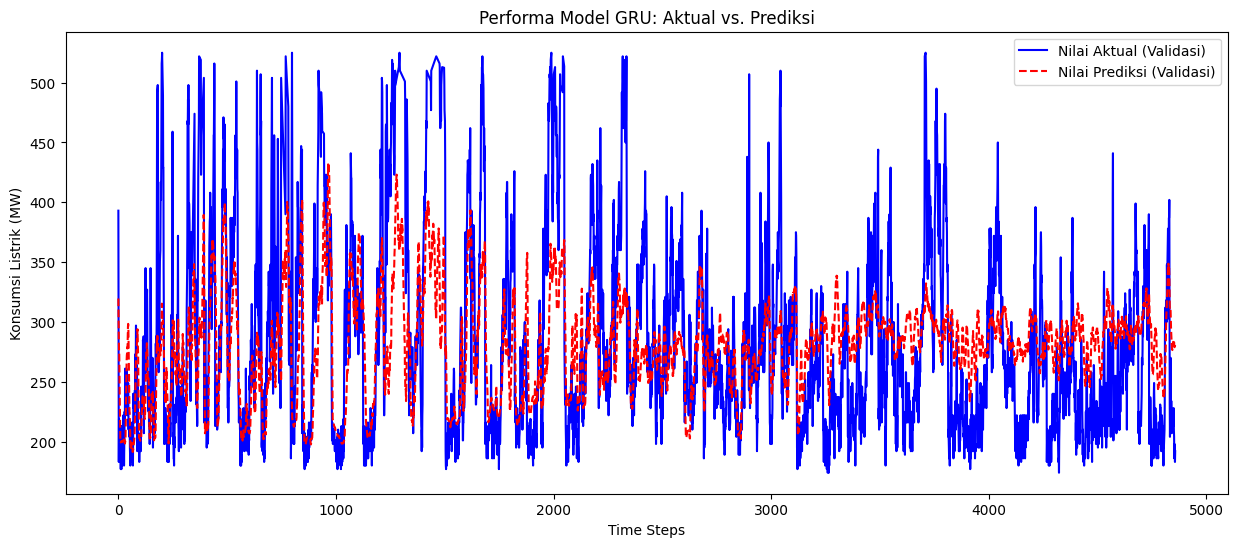

In [23]:
# Pastikan y_val_actual dan val_predictions sudah terdefinisi
y_val_actual = scaler_y.inverse_transform(y_val)
val_predictions_scaled = model_lstm.predict(X_val)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled)

# Visualisasi hasil pada data validasi
plt.figure(figsize=(15, 6))
plt.plot(y_val_actual, label='Nilai Aktual (Validasi)', color='blue')
plt.plot(val_predictions, label='Nilai Prediksi (Validasi)', color='red', linestyle='--')
plt.title('Performa Model GRU: Aktual vs. Prediksi')
plt.xlabel('Time Steps')
plt.ylabel('Konsumsi Listrik (MW)')
plt.legend()
plt.show()

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


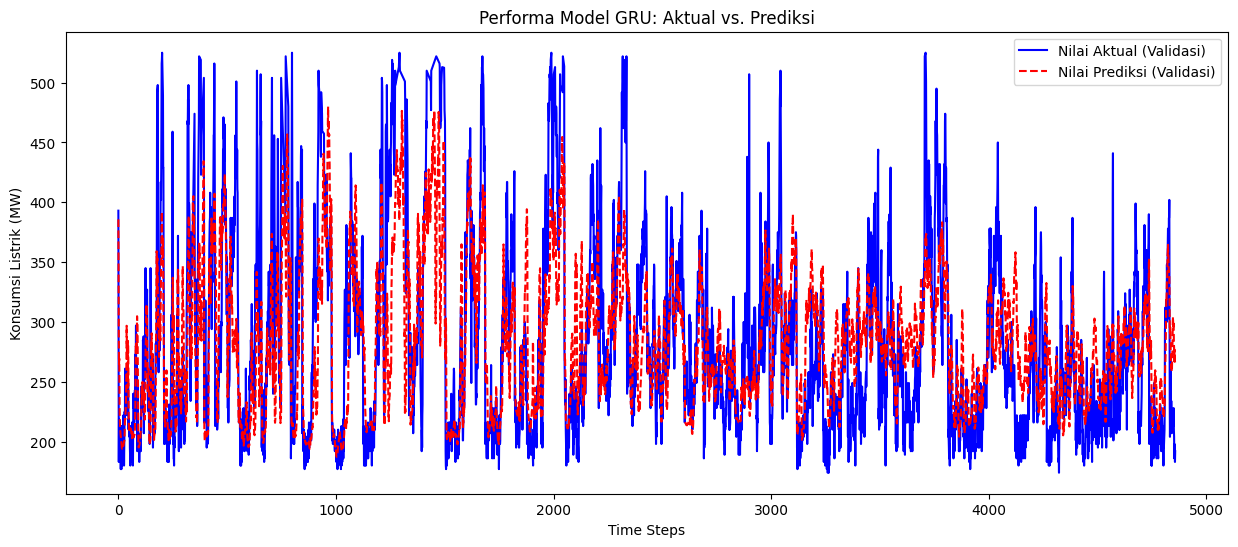

In [24]:
# Pastikan y_val_actual dan val_predictions sudah terdefinisi
y_val_actual = scaler_y.inverse_transform(y_val)
val_predictions_scaled = model_gru.predict(X_val)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled)

# Visualisasi hasil pada data validasi
plt.figure(figsize=(15, 6))
plt.plot(y_val_actual, label='Nilai Aktual (Validasi)', color='blue')
plt.plot(val_predictions, label='Nilai Prediksi (Validasi)', color='red', linestyle='--')
plt.title('Performa Model GRU: Aktual vs. Prediksi')
plt.xlabel('Time Steps')
plt.ylabel('Konsumsi Listrik (MW)')
plt.legend()
plt.show()

## Evaluasi

In [25]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

def evaluate_model(y_true, y_pred, model_name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\nMetrik Evaluasi pada Data Validasi ({model_name}):")
    print(f'MSE = {mse:.4f}')
    print(f'RMSE = {rmse:.4f}')
    print(f'R² = {r2:.4f}')
    print(f'MAPE = {mape:.4f}')

In [26]:
# ### Evaluasi Model Individual dan Ensemble
print("\n--- Mengevaluasi Model ---")
y_val_actual = scaler_y.inverse_transform(y_val)


--- Mengevaluasi Model ---


In [27]:
# Prediksi GRU
val_pred_gru_scaled = model_gru.predict(X_val)
val_pred_gru = scaler_y.inverse_transform(val_pred_gru_scaled)
evaluate_model(y_val_actual, val_pred_gru, "GRU")

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrik Evaluasi pada Data Validasi (GRU):
MSE = 3675.5097
RMSE = 60.6260
R² = 0.5177
MAPE = 0.1492


In [28]:
# Prediksi LSTM
val_pred_lstm_scaled = model_lstm.predict(X_val)
val_pred_lstm = scaler_y.inverse_transform(val_pred_lstm_scaled)
evaluate_model(y_val_actual, val_pred_lstm, "LSTM")

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Metrik Evaluasi pada Data Validasi (LSTM):
MSE = 4988.1351
RMSE = 70.6267
R² = 0.3454
MAPE = 0.1793


In [29]:
# Prediksi Ensemble (Averaging)
ensemble_val_pred = (val_pred_gru + val_pred_lstm) / 2.0
evaluate_model(y_val_actual, ensemble_val_pred, "Ensemble")


Metrik Evaluasi pada Data Validasi (Ensemble):
MSE = 4091.9152
RMSE = 63.9681
R² = 0.4630
MAPE = 0.1594


In [30]:
# Membuat File Submission dari Ensemble
print("\n--- Membuat Prediksi untuk Data Test ---")
X_test_scaled = scaler_X.transform(df_test_final.values)
combined_data = np.concatenate([X_scaled[-TIME_STEPS:], X_test_scaled])
X_test_seq = []
for i in range(len(X_test_scaled)):
    X_test_seq.append(combined_data[i:i + TIME_STEPS])
X_test_seq = np.array(X_test_seq)


--- Membuat Prediksi untuk Data Test ---


## Prediction

In [32]:
# Membuat File Submission
print("\n--- Membuat Prediksi untuk Data Test ---")
X_test_scaled = scaler_X.transform(df_test_final.values)
combined_data = np.concatenate([X_scaled[-TIME_STEPS:], X_test_scaled])
X_test_seq = []
for i in range(len(X_test_scaled)):
    X_test_seq.append(combined_data[i:i + TIME_STEPS])
X_test_seq = np.array(X_test_seq)

# Prediksi dari kedua model
test_pred_gru_scaled = model_gru.predict(X_test_seq)
test_pred_gru = scaler_y.inverse_transform(test_pred_gru_scaled)

test_pred_lstm_scaled = model_lstm.predict(X_test_seq)
test_pred_lstm = scaler_y.inverse_transform(test_pred_lstm_scaled)

# Gabungkan prediksi
ensemble_test_pred = (test_pred_gru + test_pred_lstm) / 2.0

# Buat dataframe untuk submission
submission_df = pd.DataFrame({'ID': test_ids, 'konsumsi_listrik': ensemble_test_pred.flatten()})
submission_df.to_csv('gru_lstm.csv', index=False)

print("\nFile submission 'submission_gru_lstm.csv' berhasil dibuat.")
print(submission_df.head())


--- Membuat Prediksi untuk Data Test ---
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

File submission 'submission_gru_lstm.csv' berhasil dibuat.
      ID  konsumsi_listrik
0  32184        272.644043
1  32185        264.848755
2  32186        259.658478
3  32187        251.303925
4  32188        255.993790



--- Menampilkan Visualisasi Prediksi Ensemble pada Data Test ---


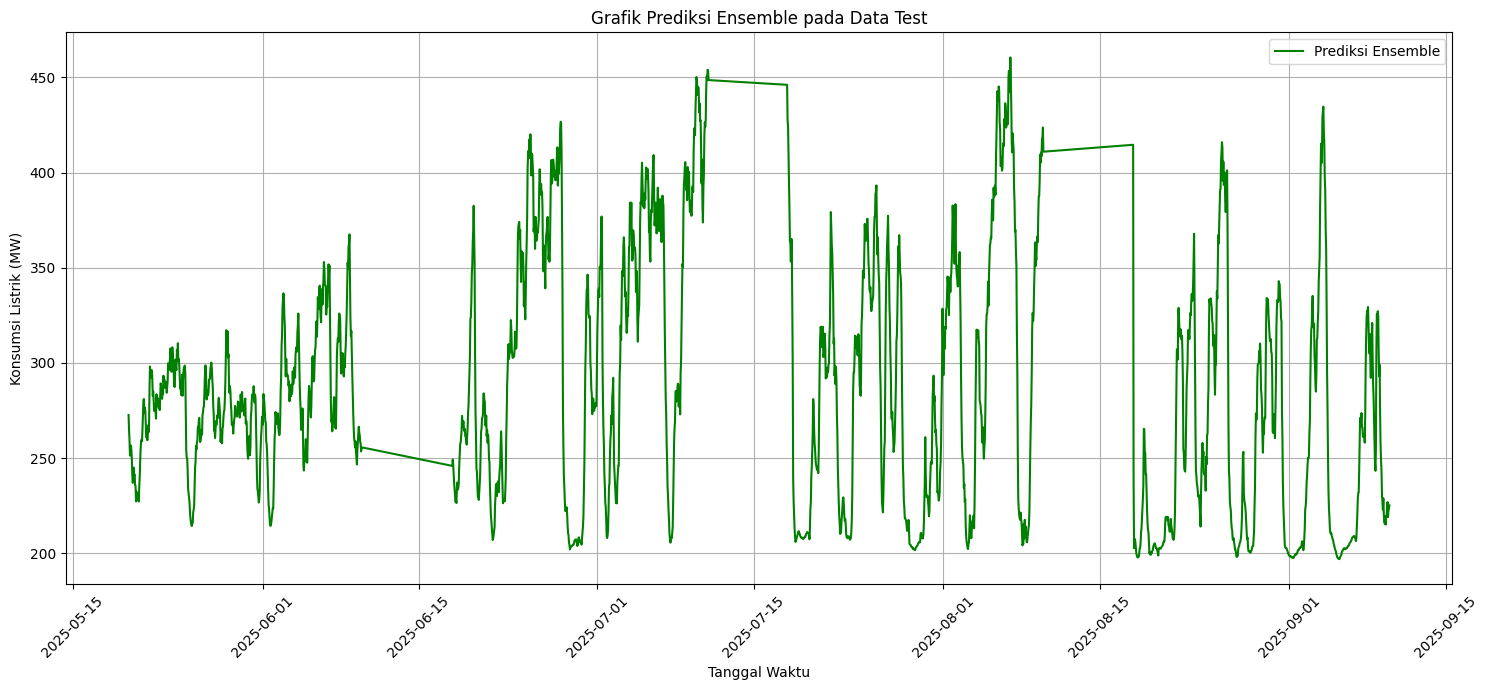

In [33]:
print("\n--- Menampilkan Visualisasi Prediksi Ensemble pada Data Test ---")
plt.figure(figsize=(15, 7))
plt.plot(test_dates, submission_df['konsumsi_listrik'], label='Prediksi Ensemble', color='green')
plt.title('Grafik Prediksi Ensemble pada Data Test')
plt.xlabel('Tanggal Waktu')
plt.ylabel('Konsumsi Listrik (MW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()